In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import pandas as pd
import seaborn as sns
import pickle

# aes
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import rc
# rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':12})
# rc('text', usetex=True)

sns.set_context("notebook", font_scale=1.25)
 
file_path = "turl_test_2k_prompts_50.jsonl"
device = torch.device("mps")

model_name = "osunlp/TableLlama"
config = transformers.AutoConfig.from_pretrained(model_name)
orig_ctx_len = getattr(config, "max_position_embeddings", None)
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=orig_ctx_len, padding_side="left", use_fast=False)

In [3]:
# prompt formatting

PROMPT_DICT = {
    "prompt_input": (
        "Below is an instruction that describes a task, paired with an input that provides further context. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Input:\n{input_seg}\n\n### Question:\n{question}\n\n### Response:"
    ),
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
}

def generate_prompt(instruction, question, input_seg=None):
    question += " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    if input_seg:
        return PROMPT_DICT["prompt_input"].format(instruction=instruction, input_seg=input_seg, question=question)
    else:
        return PROMPT_DICT["prompt_no_input"].format(instruction=instruction)

In [4]:
# load questions (to be removed)

file_path = "turl_test_2k_prompts_50.jsonl"

with open(file_path, "r", encoding="utf-8") as f:
    prompts = [json.loads(line) for line in f]

In [5]:
!ls 

1800.pickle                          prompt100.py
644sample                            prompt100gemmalocal.py
644sample-multi                      prompt100tablellama.py
README.md                            prompt_wip.py
TableLlama.2073770127.pickle         prompt_wip_sel.py
TableLlama.3729511693.pickle         runner.py
Untitled.ipynb                       select_errors_from_1800.ipynb
cohesion.ipynb                       selected_pids.644.pickle
cohesion.pickle                      selected_pids.688.pickle
delme.xlsx                           tablellama-classifier.ipynb
gemma-2-2b-it.3892595837.pickle      tablellama-multipass.ipynb
gemma-2-9b-it-4bit.3246737286.pickle tablellama-plot copy.ipynb
jensension.ipynb                     tablellama-plot.ipynb
logits-tablellama.ipynb              tablellama.preprocessed.pickle
mirror                               tablellama10runs
older tablellama                     test
pdf                                  turl_test_2k_prompts_50.jsonl
pre

In [34]:
%%time

# load processed data

import os
import pickle
from copy import deepcopy

prefix = './644sample-multi/' # runs on 344 prompts with at least 1 error and 344 prompts with no error

run = 0
outlist = []

for file in os.listdir(prefix):
    if file.endswith('pickle'):
        print(file)
        with open(os.path.join(prefix, file), 'rb') as handle:
            outlist_ = pickle.load(handle)
            for pid, item in enumerate(tqdm(outlist_)):
                # explode multiruns
                for i, _ in enumerate(item["post_output_sequences"]):
                    item_ = deepcopy(item)
                    item_["post_output_sequences"] = item["post_output_sequences"][i]
                    item_["post_output_proba_topn"] = item["post_output_proba_topn"][i]
                    item_["post_output_proba_topk"] = item["post_output_proba_topk"][i]
                    item_["post_output_true_entropies"] = item["post_output_true_entropies"][i] 
                    item_["run"] = run + i
                    outlist.append(item_)
            run = run + i + 1 # next file

len(outlist)

TableLlama.3464191535.pickle


100%|█████████████████████████████████████████| 688/688 [03:05<00:00,  3.71it/s]

CPU times: user 20min 5s, sys: 1min 31s, total: 21min 37s
Wall time: 3min 18s


2064

In [35]:
len(outlist_), len(outlist), outlist[-1]['run']

(688, 2064, 2, 1)

### check output against ground truth

In [145]:
%%time

# show results

c=0
t=0
h=0

truth = []
outseq = []

for idx, p in enumerate(outlist):
    print(idx, end='\r')
    c+=1
    # in
    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    # computed
    # post_output_scores = p['post_output_scores']
    post_output_sequences = p['post_output_sequences']
    # bases
    baseid = len(inputs["input_ids"][0]) + 1
    endid = len(post_output_sequences[0])
    # lookout
    generated_ids = post_output_sequences
    generated_text = tokenizer.decode(generated_ids[0][baseid:endid], skip_special_tokens=True)
    # print
    # print(generated_text)
    # print(p['output'])
    # print('\n')
    #test
    a = generated_text.lower().strip()
    b = p['output'].lower().strip()
    # correct
    correct = False
    hallucinated = False
    if (a in b) or (b in a) or (b.startswith(a)) or (a.startswith(b)): 
        correct = True
        t+=1
    # hallucinated
    elif a not in prompt.lower().strip(): 
        h+=1
        hallucinated = True
    # incorrect
    else:
        pass
        #print(generated_text)
        #print(p['output'])
        #print('\n')
        # print(prompt)
        # print('\n')
        
    truth.append((p['run'], p['pid'], correct, hallucinated))
    outseq.append((p['run'], p['pid'], generated_text, post_output_sequences, b))

CPU times: user 15.2 s, sys: 545 ms, total: 15.8 s
Wall time: 17 s


In [146]:
# true, hallucinated, counted
t, h, c

(1435, 69, 2064)

In [147]:
truth = pd.DataFrame(truth, columns=['run', 'pid', 'correct', 'hallucinated'])

In [148]:
truth.describe(include='all')

,run,pid,correct,hallucinated
count,2064.000000,2064.000000,2064,2064
unique,NaN,NaN,2,2
top,NaN,NaN,True,False
freq,NaN,NaN,1435,1995
mean,1.000000,901.360465,NaN,NaN
std,0.816694,519.119216,NaN,NaN
min,0.000000,9.000000,NaN,NaN
25%,0.000000,449.250000,NaN,NaN
50%,1.000000,883.000000,NaN,NaN
75%,2.000000,1366.750000,NaN,NaN


<Axes: xlabel='correct', ylabel='Count'>

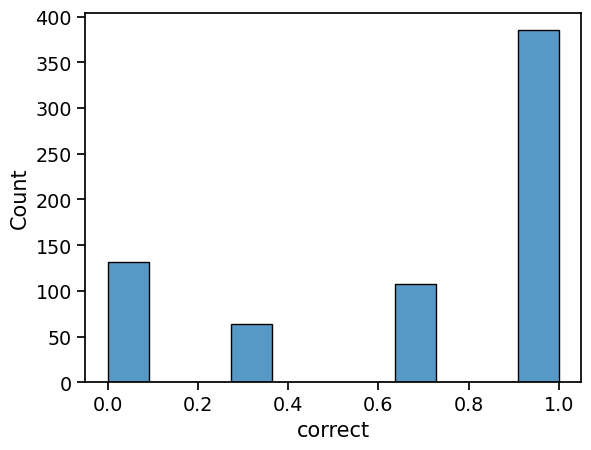

In [149]:
sns.histplot(truth.groupby('pid').correct.mean())

<Axes: xlabel='hallucinated', ylabel='Count'>

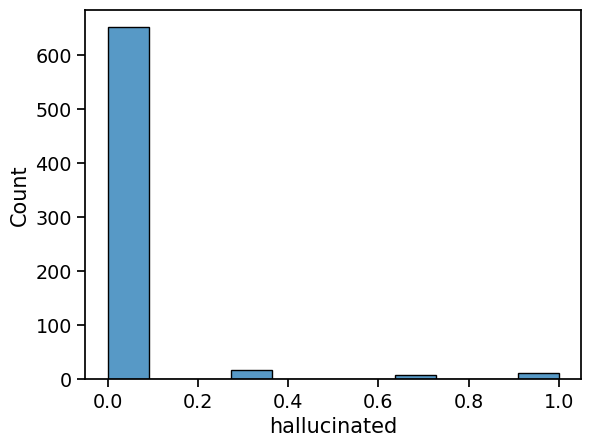

In [150]:
sns.histplot(truth.groupby('pid').hallucinated.mean())

In [151]:
truth.groupby('pid').size().value_counts()

3    688
Name: count, dtype: int64

In [152]:
truth

,run,pid,correct,hallucinated
0,0,9,False,False
1,1,9,False,False
2,2,9,True,False
3,0,10,False,False
4,1,10,False,False
...,...,...,...,...
2059,1,1794,True,False
2060,2,1794,True,False
2061,0,1797,False,True
2062,1,1797,False,True


In [153]:
accu = truth.groupby('pid').correct.mean()

In [154]:
accu[accu<1.].shape

(303,)

In [155]:
accu.value_counts()

correct
1.000000    385
0.000000    131
0.666667    108
0.333333     64
Name: count, dtype: int64

In [156]:
# answers
answers = pd.DataFrame(outseq, columns=['run', 'pid', 'answer', 'answer_seq', 'right_answer'])
answers.answer = answers.answer.str[:-1]

### sequence components alignment
### (build "segments" for each sequence)

In [48]:
def is_sublist(c, m, label):
    if not c: return False
    if not m or len(c) > len(m): return False

    for i in range(len(m) - len(c) + 1):
        if m[i:i+len(c)] == c:
            return (i, i + len(c), label)
    return False

In [49]:
%%time

checks = []
alls = set()

for idx, p in enumerate(outlist):
    
    print(idx, end='\r')
    
    run = p['run']
    pid = p['pid']
    
    alls.add(p['table'])

    prompt = generate_prompt(p["instruction"], p["question"], p["input"])
    output_seq = p['post_output_sequences'][0]

    prompt_seq = tokenizer(prompt, return_tensors="pt")
    prompt_seq = prompt_seq['input_ids'][0].numpy().tolist()

    instruction_seq = tokenizer(p["instruction"], return_tensors="pt")
    instruction_seq = instruction_seq['input_ids'][0].numpy().tolist()

    question_seq = tokenizer(p["question"], return_tensors="pt")
    question_seq = question_seq['input_ids'][0].numpy().tolist()

    input_seq = tokenizer(p["input"], return_tensors="pt")
    input_seq = input_seq['input_ids'][0].numpy().tolist()

    postilla = " Answer with just a candidate, selected from the provided referent entity candidates list, and nothing else. The selected candidate must be reported verbatim from the list provided as input. Each candidate in the list is enclosed between < and > and reports [DESC] and [TYPE] information."
    postilla_seq = tokenizer(postilla, return_tensors="pt")
    postilla_seq = postilla_seq['input_ids'][0].numpy().tolist()
    
    # subseq matching
    instruction_match = is_sublist(instruction_seq[2:], output_seq, 'instruction')
    input_match = is_sublist(input_seq[2:], output_seq, 'input')
    question_match = is_sublist(question_seq[2:], output_seq, 'question') # maybe include 1?
    postilla_match = is_sublist(postilla_seq[2:], output_seq, 'postilla')
    
    # boundaries are inclusive
    checks.append((run, pid, 0, instruction_match[0], 'preamble')) # preamble
    checks.append((run, pid, instruction_match[0] + 1) + instruction_match[1:])
    checks.append((run, pid, instruction_match[1] + 1) + input_match[1:]) # sew to preceding
    checks.append((run, pid, input_match[1] + 1) + question_match[1:]) # sew to preceding
    checks.append((run, pid, postilla_match[0] + 1, len(prompt_seq) - 1, 'postilla')) # stretch postilla until the end of the prompt
    checks.append((run, pid, len(prompt_seq), len(output_seq) -1, 'generated')) # assume everything else is generated

CPU times: user 35.3 s, sys: 407 ms, total: 35.7 s
Wall time: 35.7 s


In [50]:
# check the checks (must be False)
'False' in checks

False

In [51]:
segments = pd.DataFrame(checks, columns = ['run', 'pid', 'start', 'end', 'segment'])

In [52]:
segments['seq'] = segments.segment.map({'preamble': 0, 'instruction': 1, 'input': 2, 'question': 3, 'postilla': 4, 'generated': 5})

In [53]:
segments['length'] = segments.end - segments.start

In [54]:
segments

,run,pid,start,end,segment,seq,length
0,0,9,0,40,preamble,0,40
1,0,9,41,135,instruction,1,94
2,0,9,136,5117,input,2,4981
3,0,9,5118,6405,question,3,1287
4,0,9,6406,6470,postilla,4,64
...,...,...,...,...,...,...,...
12379,2,1797,41,135,instruction,1,94
12380,2,1797,136,859,input,2,723
12381,2,1797,860,5398,question,3,4538
12382,2,1797,5399,5463,postilla,4,64


### segment description

In [55]:
avg_seq_widths = segments.groupby(['segment', 'seq']).length.agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('seq')
avg_seq_widths = avg_seq_widths.rename(columns = {'mean': 'avg_length', 
                                                  'std': 'std_length', 
                                                  'min': 'min_length',
                                                  'max': 'max_length'})
avg_seq_widths['avg_length_rel'] = avg_seq_widths['avg_length'] / avg_seq_widths['avg_length'].sum()
avg_seq_widths['avg_cumlen'] = avg_seq_widths['avg_length_rel'].cumsum() 
avg_seq_widths

,segment,seq,avg_length,std_length,min_length,max_length,avg_length_rel,avg_cumlen
4,preamble,0,40.000000,0.000000,40,40,0.012028,0.012028
2,instruction,1,94.000000,0.000000,94,94,0.028266,0.040294
1,input,2,1825.149709,1572.813630,141,6987,0.548819,0.589113
5,question,3,1277.675872,399.458459,79,4543,0.384195,0.973308
3,postilla,4,64.000000,0.000000,64,64,0.019245,0.992552
0,generated,5,24.768411,5.884380,13,56,0.007448,1.000000


<Axes: xlabel='length', ylabel='Count'>

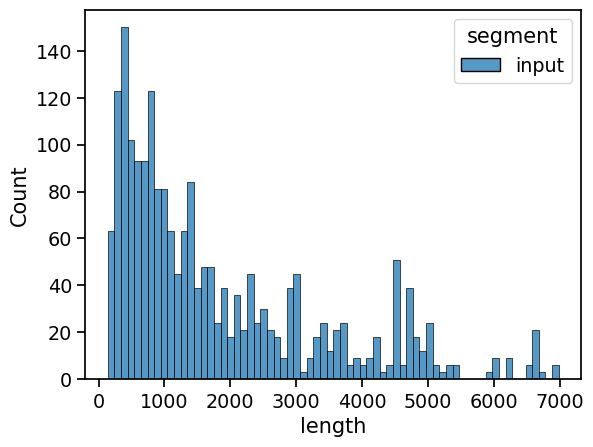

In [56]:
sns.histplot(segments[segments.segment=='input'], x='length', hue='segment', multiple='dodge', binwidth=100)

<Axes: xlabel='length'>

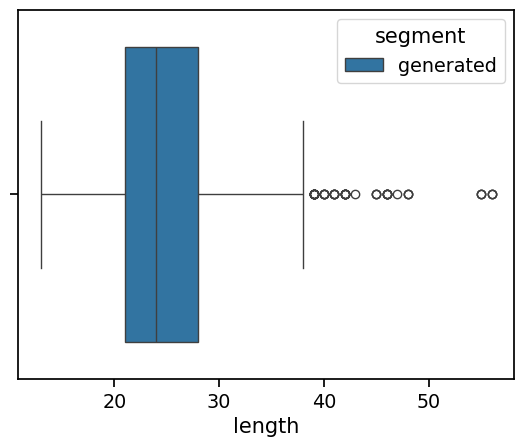

In [57]:
sns.boxplot(segments[segments.segment=='generated'], x='length', hue='segment')

<Axes: xlabel='segment', ylabel='length'>

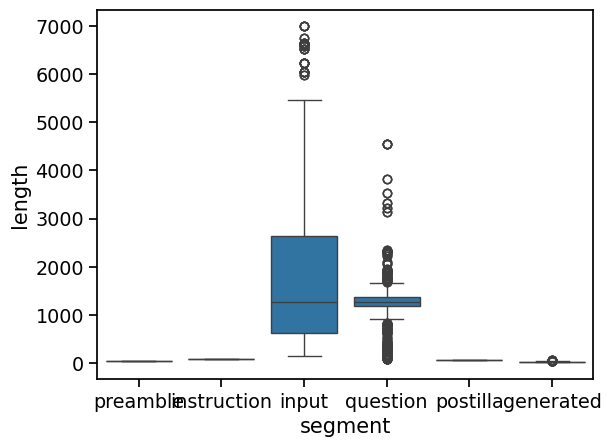

In [58]:
sns.boxplot(segments, y='length', x='segment')

In [59]:
# Define background regions [(start, end, color, label)] based on the cumulative sections spans (for the first viz above)

from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

myl = avg_seq_widths.avg_cumlen.to_list()
sections = ['preamble', 'instruction', 'input', 'question', 'postilla', 'generated']


first = (0., myl[0], palette[0], sections[0])
background_regions = [first]

for z1, z2, l, i in zip(myl, myl[1:], sections[1:], range(len(myl))):
    background_regions.append((z1,z2, palette[i+1], l))

### collect observables

In [60]:
%%time

shapes = []

# for each prompt
for i, p in enumerate(outlist):
    # for each token
    run = p['run']
    pid = p['pid']
    for j, pp in enumerate(p['pre_output_proba_topn']):
        shapes.append((run,pid,j,'prompt',
                           len(pp['top_n_indices']),
                           p['pre_output_true_entropies'][j],
                           max(pp['top_n_probs'])))
    for jj, pp in enumerate(p['post_output_proba_topn']):
        shapes.append((run,pid,j+jj+1,'generated',
                           len(pp['top_n_indices']),
                           p['post_output_true_entropies'][jj],
                           max(pp['top_n_probs'])))

CPU times: user 5.15 s, sys: 128 ms, total: 5.28 s
Wall time: 5.27 s


In [61]:
%%time 

import pandas as pd
import numpy as np
d = pd.DataFrame(shapes, columns=['run', 'pid', 'tok', 'area', 'shape', 'true_ent', 'maxp'])

CPU times: user 3.67 s, sys: 257 ms, total: 3.93 s
Wall time: 3.92 s


In [62]:
# are the max index equal in observables and segments (must be True)
d.groupby(['run','pid']).tok.max().sort_values().reset_index(drop=True).equals(segments.groupby(['run','pid']).end.max().sort_values().reset_index(drop=True))

True

In [63]:
# (first 10 in generated)
d[d.area=='prompt'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.tail(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,1.000000,901.360465,3300.325581,6.872820,0.594069,0.842458
std,0.816516,519.006018,1603.612015,32.147978,0.930705,0.238387
min,0.000000,9.000000,488.000000,1.000000,0.000000,0.086365
25%,0.000000,449.250000,2078.750000,1.000000,0.000113,0.714233
50%,1.000000,883.000000,2775.500000,1.000000,0.016675,0.998047
75%,2.000000,1366.750000,4206.500000,2.000000,0.898675,1.000000
max,2.000000,1797.000000,8230.000000,946.000000,5.685452,1.000000


In [64]:
# (last 10 in prompt)
d[d.area=='generated'].groupby(['run', 'pid'], group_keys=False).apply(lambda x: x.head(10)).describe()

,run,pid,tok,shape,true_ent,maxp
count,20640.000000,20640.000000,20640.000000,20640.000000,2.064000e+04,20640.000000
mean,1.000000,901.360465,3310.325581,1.060659,4.367993e-02,0.983616
std,0.816516,519.006018,1603.612015,0.334120,1.713021e-01,0.073194
min,0.000000,9.000000,498.000000,1.000000,6.144181e-10,0.163075
25%,0.000000,449.250000,2088.750000,1.000000,5.495846e-07,0.999936
50%,1.000000,883.000000,2785.500000,1.000000,8.705355e-06,1.000000
75%,2.000000,1366.750000,4216.500000,1.000000,7.383894e-04,1.000000
max,2.000000,1797.000000,8240.000000,10.000000,2.319561e+00,1.000000


In [65]:
%%time

# attach sections

m = d.merge(segments, on=['run','pid'], how='left')
m = m[(m.start <= m.tok) & (m.tok <= m.end)]

CPU times: user 2.78 s, sys: 986 ms, total: 3.77 s
Wall time: 3.77 s


In [66]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40
...,...,...,...,...,...,...,...,...,...,...,...,...
41258435,2,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23
41258441,2,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23
41258447,2,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23
41258453,2,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23


In [67]:
# did we merge all the tokens to their segments (must be True)
d[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True).equals(m[['run', 'pid', 'tok']].sort_values(['run', 'pid', 'tok']).reset_index(drop=True))

True

In [68]:
# check that all the six sections are present in each prompt (must be True)
m.drop_duplicates(['pid', 'segment']).shape[0] == m.pid.nunique() * 6

True

In [69]:
# token position normalization

# normalized per section, offset by section sequence number
m['tok_rel_segm'] = m.tok / m.end

# normalized per section, each section same width
m['tok_rel_segm_abs'] = m.seq + ((m.tok - m.start) / (m.end - m.start))

# token relative to section start
m['tokzero'] = m['tok'] - m['start']

# token relative to section end (negative)
m['tokzero_end'] = m['tok'] - m['end'] - 1

### check variances

In [70]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [71]:
m[m.segment=='preamble'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [72]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.0

In [73]:
m[m.segment=='instruction'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.0

In [74]:
m[m.segment=='question'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.28828123

In [75]:
m[m.segment=='question'].drop_duplicates('pid', keep='last')['true_ent'].var()

0.043671735

In [76]:
m[m.segment=='generated'].drop_duplicates('pid', keep='first')['true_ent'].var()

0.00060835824

In [77]:
m[m.segment=='generated'].drop_duplicates('pid', keep='last')['true_ent'].var()

5.799174e-06

In [157]:
if True:
    myoutdict = {'truth': truth, 'segments': segments, 'm': m, 'answers': answers}

    import pickle

    with open('preprocessed.pickle', 'wb') as handle:
        pickle.dump(myoutdict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [79]:
!ls -larth | grep preprocessed

-rw-r--r--   1 bono  staff    16M Feb 20 20:07 tablellama.preprocessed.pickle
-rw-r--r--   1 bono  staff   1.3G Mar 12 11:49 preprocessed.pickle.old
-rw-r--r--   1 bono  staff   788M Mar 13 09:38 preprocessed.pickle


In [80]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']
answers = mydict['answers']

In [81]:
m

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258435,2,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
41258441,2,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
41258447,2,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
41258453,2,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [82]:
m.area.unique()

array(['prompt', 'generated'], dtype=object)

In [83]:
mm = m.copy()

### single run plots

In [84]:
m = mm[mm.run==0].copy()

In [85]:
NUM_BINS = 100

100


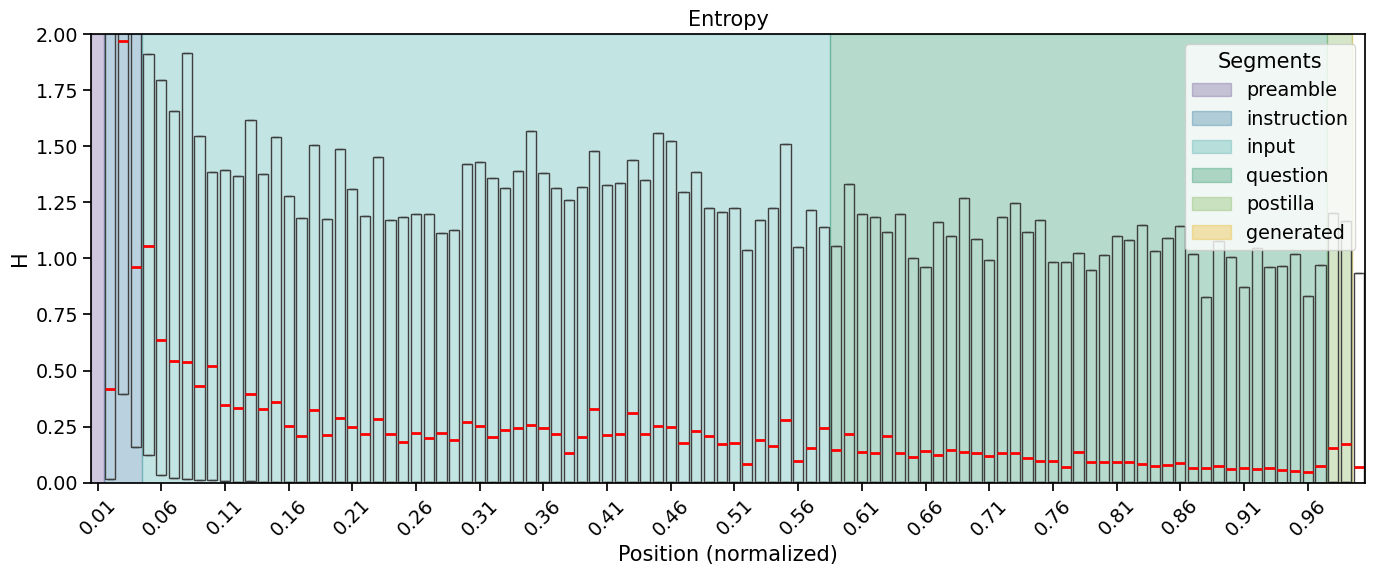

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.set(ylim=(0, 2))

ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [87]:
ax.figure.savefig('./pdf/entropy_per_segment.pdf',dpi=600, bbox_inches="tight")

100


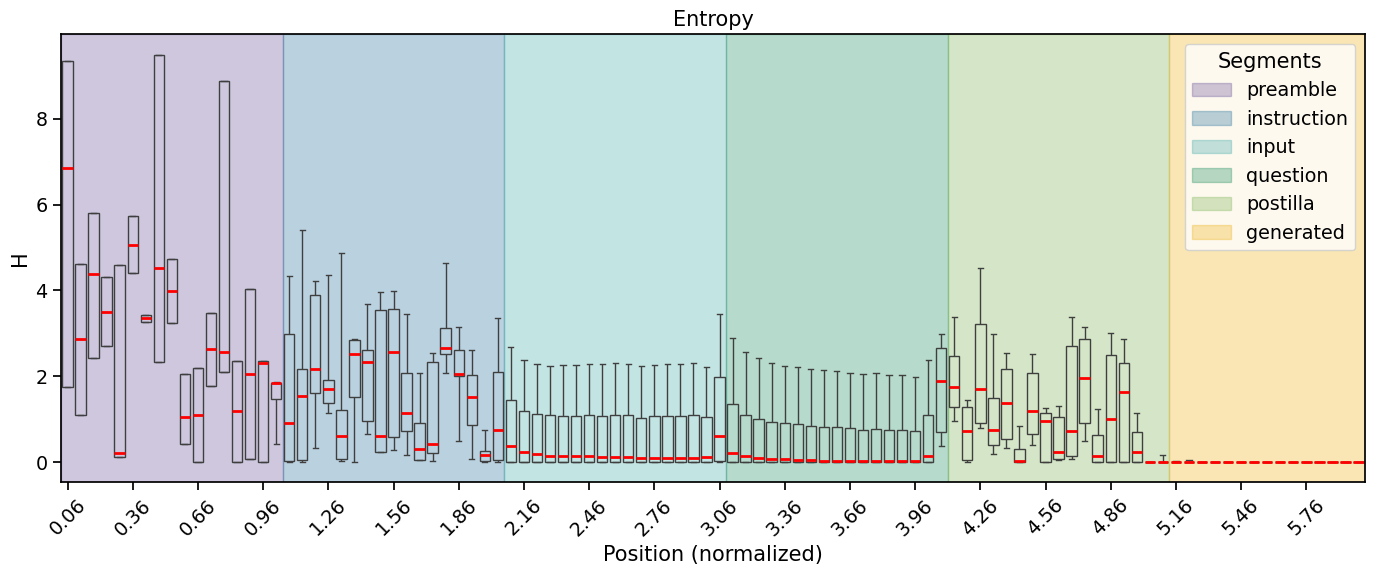

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm_abs'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))


patches = []
c = -0.5
delta = int(len(bks)/6)+1
for start, end, color, label in background_regions:
    ax.axvspan(c, c+delta, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 
    c += delta

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [89]:
ax.figure.savefig('./pdf/entropy_per_segment_unnorm.pdf',dpi=600, bbox_inches="tight")

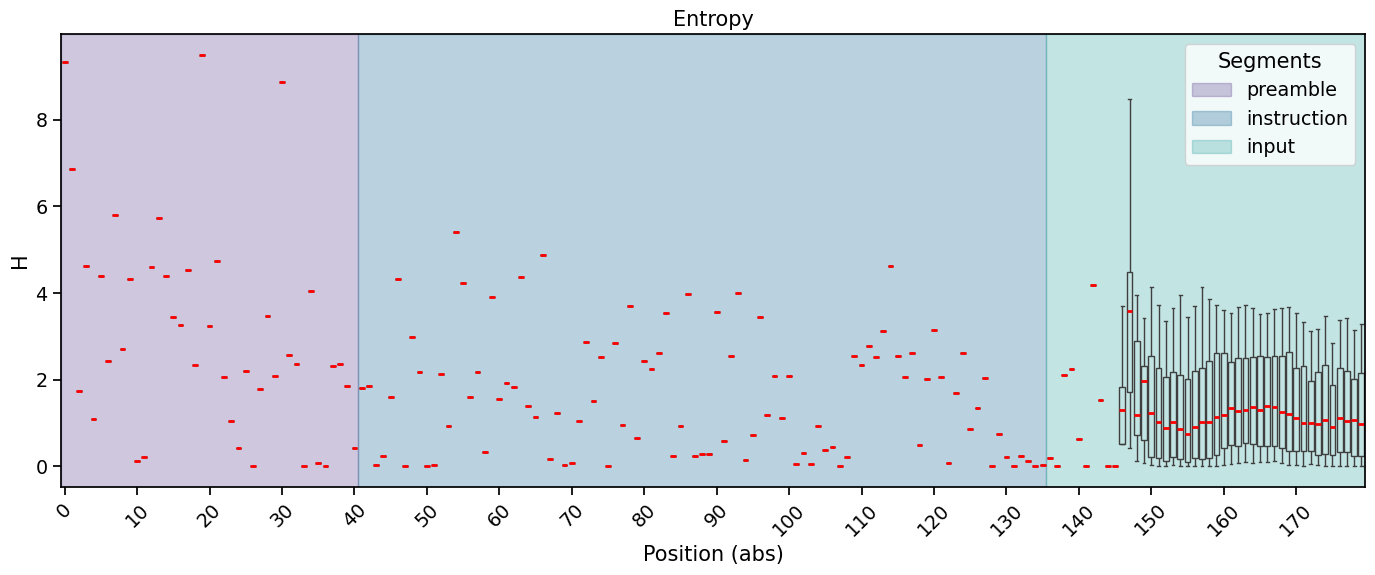

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = m[m.tok<180]

background_regions_ = [
    (0.0, 40.0, palette[0], 'preamble'),
    (41.0, 135.0, palette[1], 'instruction'),
    (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start -0.5, end + 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tok", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
ax.xaxis.set_major_locator(MaxNLocator(nbins=20))
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [91]:
segments.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [92]:
ax.figure.savefig('./pdf/entropy_beginning.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between input and question

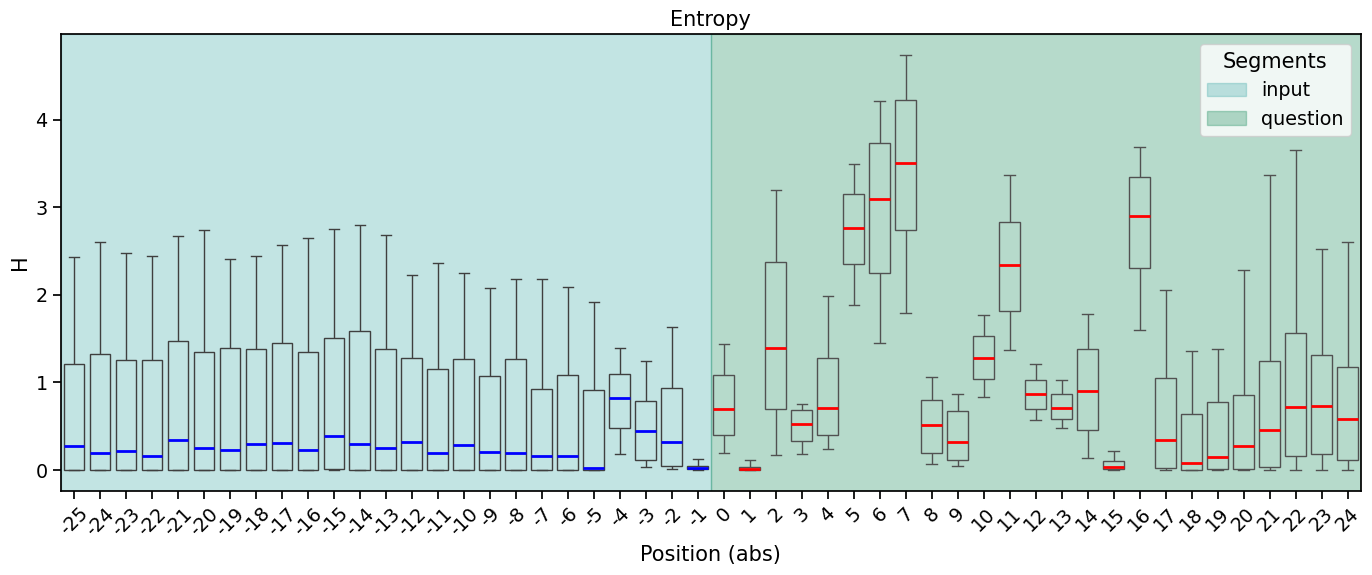

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'input') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[2], 'input'),
    (delta, 2*delta, palette[3], 'question'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'question') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")
plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [94]:
ax.figure.savefig('./pdf/entropy_boundary_input_and_question.pdf',dpi=600, bbox_inches="tight")

### absolute boundary between  question and postilla

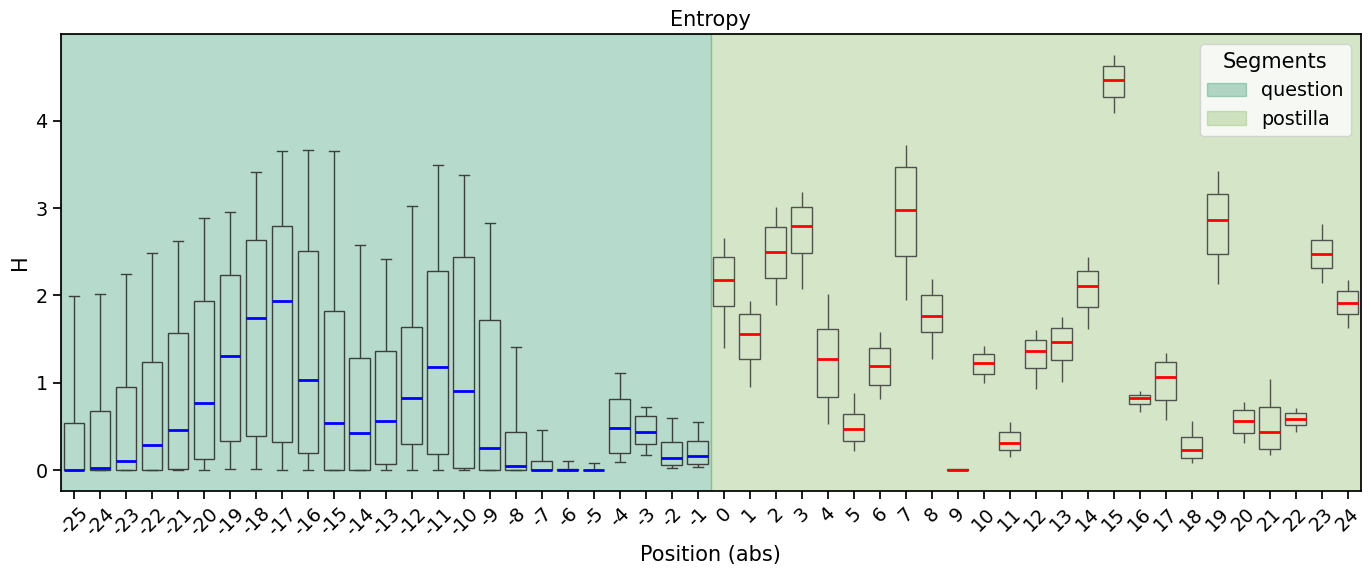

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'question') & (m.tokzero_end >= -delta))] #  

postillalen = m[m.segment=='postilla'].tokzero.max()

background_regions_ = [
    (0, delta, palette[3], 'question'),
    (delta, 2 * delta + 1, palette[4], 'postilla'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'postilla') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=False,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (abs)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [96]:
ax.figure.savefig('./pdf/entropy_boundary_question_and_postilla.pdf',dpi=600, bbox_inches="tight")

### boundary between postilla and generated

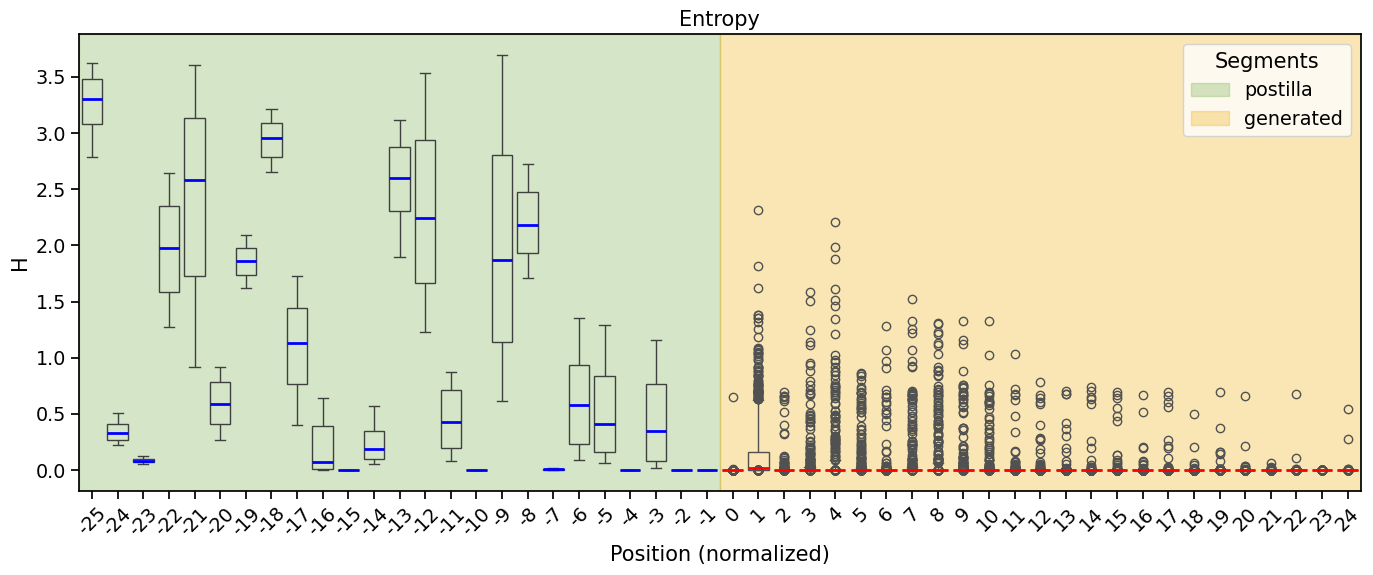

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)


# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [98]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_97307/2463233701.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_97307/2463233701.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


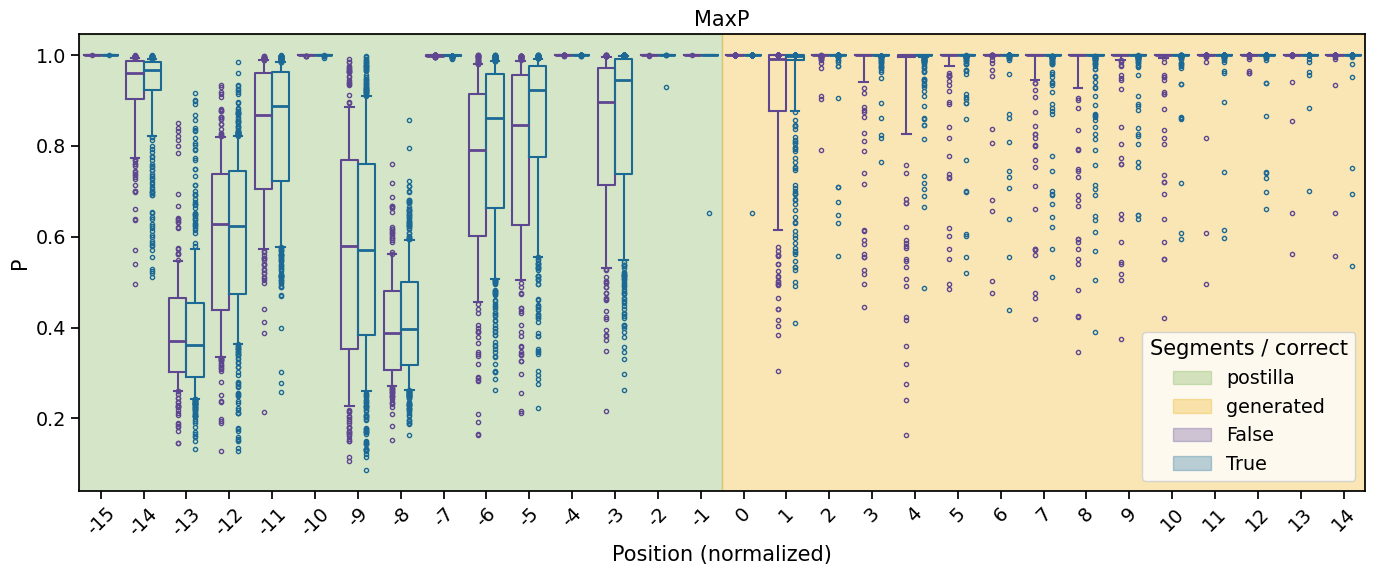

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

In [100]:
ax.figure.savefig('./pdf/entropy_boundary_postilla_and_generated_grouped_by_correct.pdf',dpi=600, bbox_inches="tight")

/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_97307/2499406647.py:30: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(
/var/folders/kn/n2krf1q970d6cfl43cjq73s80000gn/T/ipykernel_97307/2499406647.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(


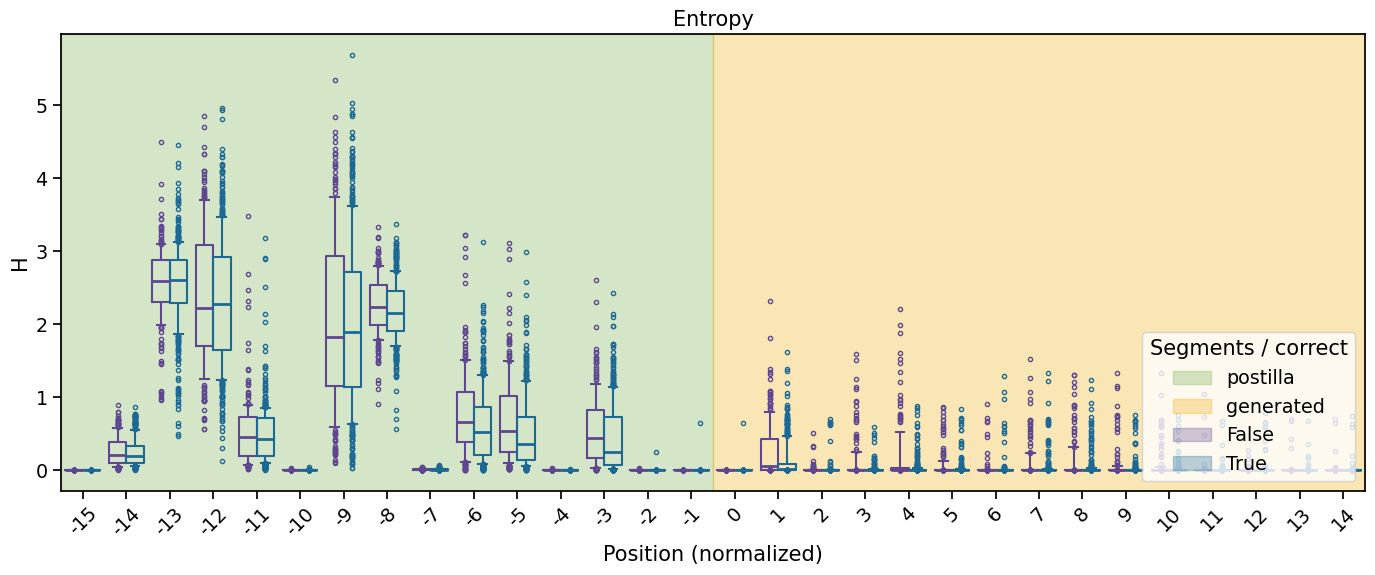

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 15
m_ = m[ ((m.segment == 'postilla') & (m.tokzero_end >= -delta))] #  
m_ = m_.merge(truth, on=['run', 'pid'])


background_regions_ = [
    (0, delta, palette[4], 'postilla'),
    (delta, 2 * delta + 1, palette[5], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero_end", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

m_ = m[ (m.segment == 'generated') & (m.tokzero < delta) ]
m_ = m_.merge(truth, on=['run', 'pid'])

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    # boxprops={'facecolor': 'none'},
    # medianprops={'color': 'red', 'linewidth': 2},
    medianprops={'linewidth': 2},
    hue='correct',
    fill=False,
    palette=palette,
    flierprops = {'marker':'o', 'markersize':3},
    ax = ax
)

patches.append(mpatches.Patch(color=palette[0], alpha=0.3, label='False'))
patches.append(mpatches.Patch(color=palette[1], alpha=0.3, label='True'))


#plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments / correct", loc="lower right")

plt.tight_layout()

plt.show()

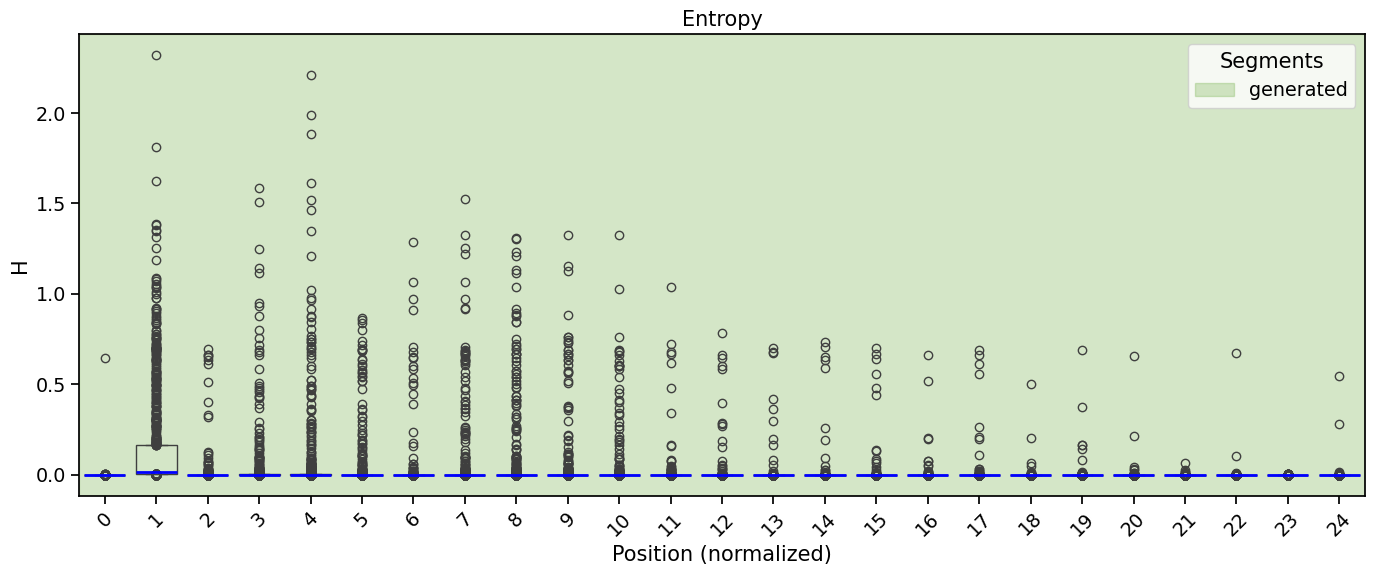

In [102]:
# only generated

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

delta = 25
m_ = m[ ((m.segment == 'generated') & (m.tokzero < delta))] #  

background_regions_ = [
    (0, delta, palette[4], 'generated'),
    #(41.0, 135.0, palette[1], 'instruction'),
    # (136.0, 1000.0, palette[2], 'input'),
    #    (3.0, 4.0, palette[3], 'question'),
    #    (4.0, 5.0, palette[4], 'postilla'),
    #    (5.0, 6.0, palette[5], 'generated')
    ]

patches = []
for start, end, color, label in background_regions_:
    ax.axvspan(start - 0.5, end - 0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    showcaps=True,        
    showfliers=True,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'blue', 'linewidth': 2},
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("H")
plt.title("Entropy")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

In [103]:
m.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [104]:
m[m.segment=='preamble'].groupby('pid').size().std()

0.0

In [105]:
m[m.segment=='instruction'].groupby('pid').size().std()

0.0

In [106]:
m[m.segment=='input'].groupby('pid').size().std()

1573.576576615972

In [107]:
m[m.tok_rel_segm_abs<1.].true_ent.var()

5.9572453

In [108]:
df[df.tok_bin_idx==0].true_ent.var()

10.00165

100


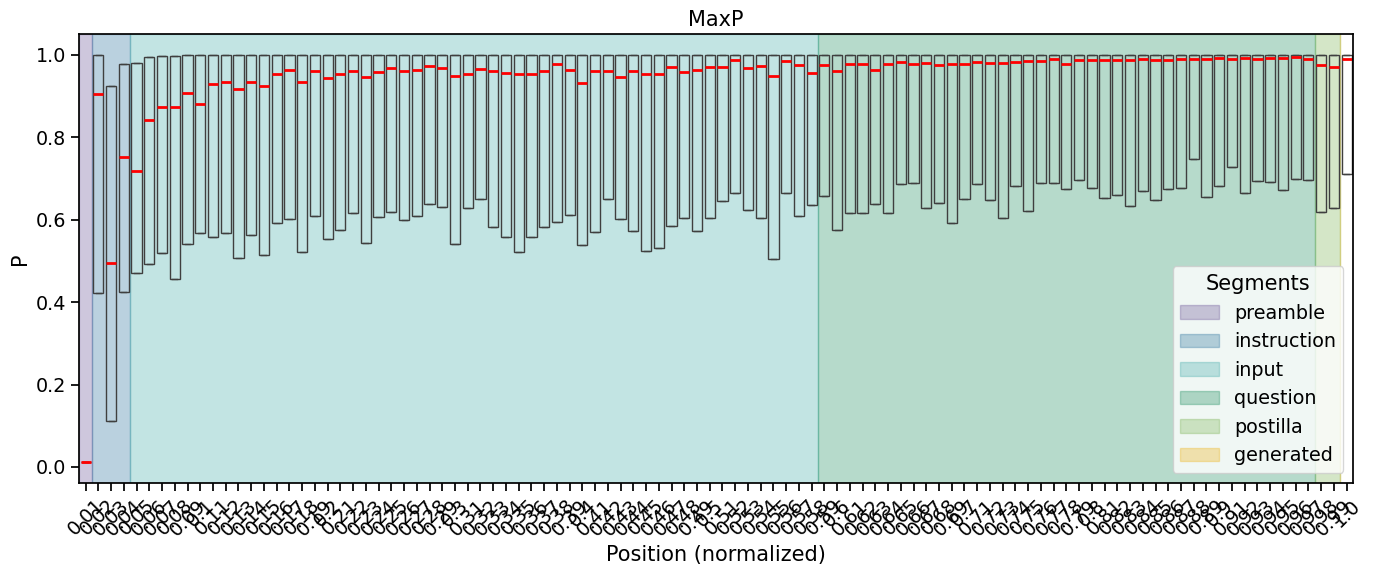

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="maxp", 
    showcaps=True,        
    showfliers=False,
    whis=[25, 75],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("MaxP")

ax.legend(handles=patches, title="Segments", loc="lower right")

plt.tight_layout()

plt.show()

100


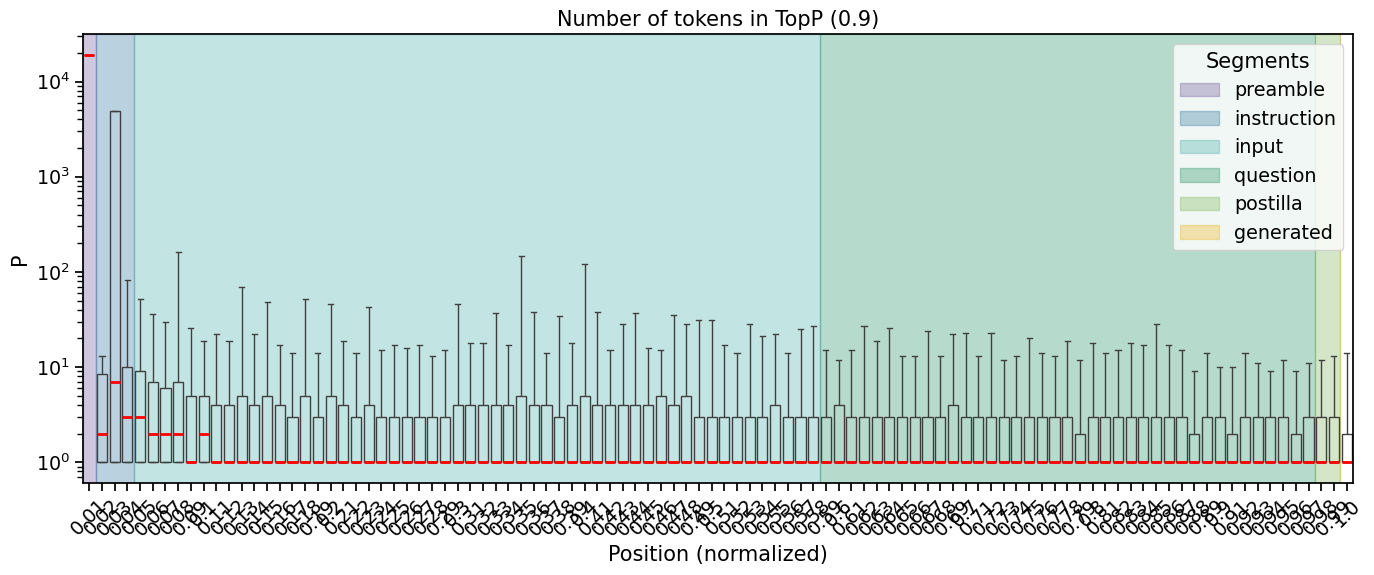

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m['tok_bin'] = pd.cut(m['tok_rel_segm'], bins=NUM_BINS)
m['tok_bin_hi'] = m['tok_bin'].apply(lambda x: x.right).astype(float)
m['tok_bin_lo'] = m['tok_bin'].apply(lambda x: x.left).astype(float)

unique_bins = np.sort(m['tok_bin_hi'].unique())  
bin_mapping = {bin_val: i for i, bin_val in enumerate(unique_bins)}
bks = list(bin_mapping.keys())

print(len(bks))

patches = []
for start, end, color, label in background_regions:
    start_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > start ][0]
    end_bin = [ n for n,i in enumerate(bin_mapping.keys()) if i > end ]
    if not end_bin: end_bin = len(bin_mapping) - 1 
    else: end_bin = end_bin[0] - 1
    ax.axvspan(bin_mapping[bks[start_bin]]-0.5, bin_mapping[bks[end_bin]]+0.5, color=color, alpha=0.3)
    patches.append(mpatches.Patch(color=color, alpha=0.3, label=label)) 

# Sort for proper order
df = m.sort_values(by=['pid', 'tok_bin_hi'])
df['tok_bin_idx'] = df['tok_bin_hi'].map(bin_mapping)  # Assign numerical index

sns.boxplot(
    data=df, 
    x="tok_bin_hi", 
    y="shape", 
    showcaps=True,        
    showfliers=False,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (normalized)")
plt.ylabel("P")
plt.title("Number of tokens in TopP (0.9)")

ax.legend(handles=patches, title="Segments", loc="upper right")

plt.tight_layout()

plt.show()

## multiple runs

### check no variance in forward

In [111]:
mm[mm.area=='prompt'].true_ent.describe()

count    6.823224e+06
mean     7.961516e-01
std      1.202175e+00
min      0.000000e+00
25%      1.045520e-03
50%      1.538483e-01
75%      1.183405e+00
max      9.495135e+00
Name: true_ent, dtype: float64

In [112]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258435,2,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
41258441,2,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
41258447,2,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
41258453,2,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [113]:
# variance before generate
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['true_ent'].var().sum()

0.0

In [114]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['shape'].var().sum()

0.0

In [115]:
mm[mm.area=='prompt'].groupby(['pid', 'tok'])['maxp'].var().sum()

0.0

In [116]:
# variance after generate
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['true_ent'].var().sum()

22.227228

In [117]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['shape'].var().sum()

96.0

In [118]:
mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var().sum()

3.8327329620169057

In [119]:
mm[mm.segment=='generated'].sort_values(['pid', 'tok'], ascending=[True,True]).to_excel("delme.xlsx")

### search prompts for which top-p varies

In [120]:
myvars = mm[mm.segment=='generated'].groupby(['pid', 'tok'])['maxp'].var()
variators = myvars[myvars>0.].to_frame().reset_index().pid.unique()

In [121]:
mv = mm[mm.pid.isin(variators)]

In [122]:
# prompts for which we observe an observable change over runs
v1 = mv.pid.unique()
v1

array([   9,   12,   14,   17,   18,   39,   41,   45,   60,   89,   94,
        109,  112,  118,  119,  125,  128,  130,  138,  177,  182,  190,
        195,  208,  209,  216,  218,  221,  224,  229,  238,  265,  266,
        270,  279,  292,  297,  298,  305,  310,  312,  318,  320,  328,
        342,  344,  352,  359,  367,  382,  391,  394,  398,  408,  421,
        446,  453,  458,  476,  482,  484,  486,  496,  511,  516,  518,
        521,  533,  561,  583,  584,  607,  613,  621,  632,  633,  639,
        658,  682,  698,  699,  700,  708,  711,  715,  717,  718,  728,
        731,  741,  753,  757,  758,  768,  777,  823,  837,  839,  847,
        854,  864,  875,  879,  880,  884,  890,  892,  902,  918,  951,
        952,  956,  976,  983,  984,  992,  994,  998, 1011, 1017, 1018,
       1023, 1034, 1044, 1061, 1069, 1070, 1071, 1073, 1088, 1094, 1099,
       1104, 1107, 1113, 1123, 1126, 1133, 1141, 1142, 1145, 1149, 1160,
       1191, 1194, 1203, 1204, 1208, 1210, 1212, 12

In [123]:
avg_truth = truth.groupby('pid').correct.mean().to_frame().reset_index()

In [124]:
# prompts for which we observe an output change over runs
v2 = avg_truth[avg_truth.correct<1.].pid.unique()
v2

array([   9,   10,   12,   14,   17,   18,   23,   41,   45,   74,   79,
         85,   86,   89,   94,  109,  112,  118,  119,  125,  128,  130,
        134,  137,  138,  139,  149,  164,  177,  182,  187,  190,  195,
        200,  208,  209,  216,  218,  221,  224,  229,  238,  265,  266,
        269,  270,  278,  279,  288,  292,  297,  298,  300,  302,  310,
        312,  318,  320,  328,  329,  330,  342,  344,  352,  359,  364,
        367,  368,  374,  382,  385,  388,  391,  394,  398,  403,  404,
        408,  409,  421,  440,  442,  446,  453,  454,  458,  476,  482,
        484,  486,  493,  496,  511,  516,  518,  521,  533,  556,  558,
        561,  583,  584,  590,  592,  607,  613,  621,  627,  628,  632,
        633,  639,  658,  682,  694,  698,  699,  700,  708,  711,  715,
        717,  718,  719,  728,  731,  741,  743,  753,  757,  758,  768,
        771,  777,  782,  788,  792,  801,  805,  810,  823,  830,  834,
        837,  839,  840,  847,  854,  864,  875,  8

In [125]:
set(v1) - set(v2)

{39, 60, 305, 1104, 1210, 1548, 1605, 1615, 1770}

In [126]:
# correctness over prompts for which observable changed over different runs
avg_truth[avg_truth.pid.isin(v1)]

,pid,correct
0,9,0.333333
2,12,0.666667
3,14,0.666667
4,17,0.666667
5,18,0.666667
...,...,...
665,1740,0.000000
672,1760,0.333333
677,1770,1.000000
680,1776,0.333333


In [127]:
# ??? correctness over prompts for which observable did NOT change over different runs
avg_truth[(~avg_truth.pid.isin(v1)) & (avg_truth.correct<1.) & (avg_truth.correct>0.)]

,pid,correct


In [128]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end,tok_bin,tok_bin_hi,tok_bin_lo
38831,0,9,6471,generated,1,7.224133e-06,1.000000,6471,6486,generated,5,15,0.997687,5.000000,0,-16,"(4.98, 5.04]",5.04,4.98
38837,0,9,6472,generated,1,5.841955e-02,0.992606,6471,6486,generated,5,15,0.997842,5.066667,1,-15,"(5.04, 5.1]",5.10,5.04
38843,0,9,6473,generated,1,5.036472e-06,1.000000,6471,6486,generated,5,15,0.997996,5.133333,2,-14,"(5.1, 5.16]",5.16,5.10
38849,0,9,6474,generated,2,7.166480e-01,0.518202,6471,6486,generated,5,15,0.998150,5.200000,3,-13,"(5.16, 5.22]",5.22,5.16
38855,0,9,6475,generated,1,1.664804e-08,1.000000,6471,6486,generated,5,15,0.998304,5.266667,4,-12,"(5.22, 5.28]",5.28,5.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41192579,0,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5,"(5.82, 5.88]",5.88,5.82
41192585,0,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4,"(5.82, 5.88]",5.88,5.82
41192591,0,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3,"(5.88, 5.94]",5.94,5.88
41192597,0,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2,"(5.94, 6.0]",6.00,5.94


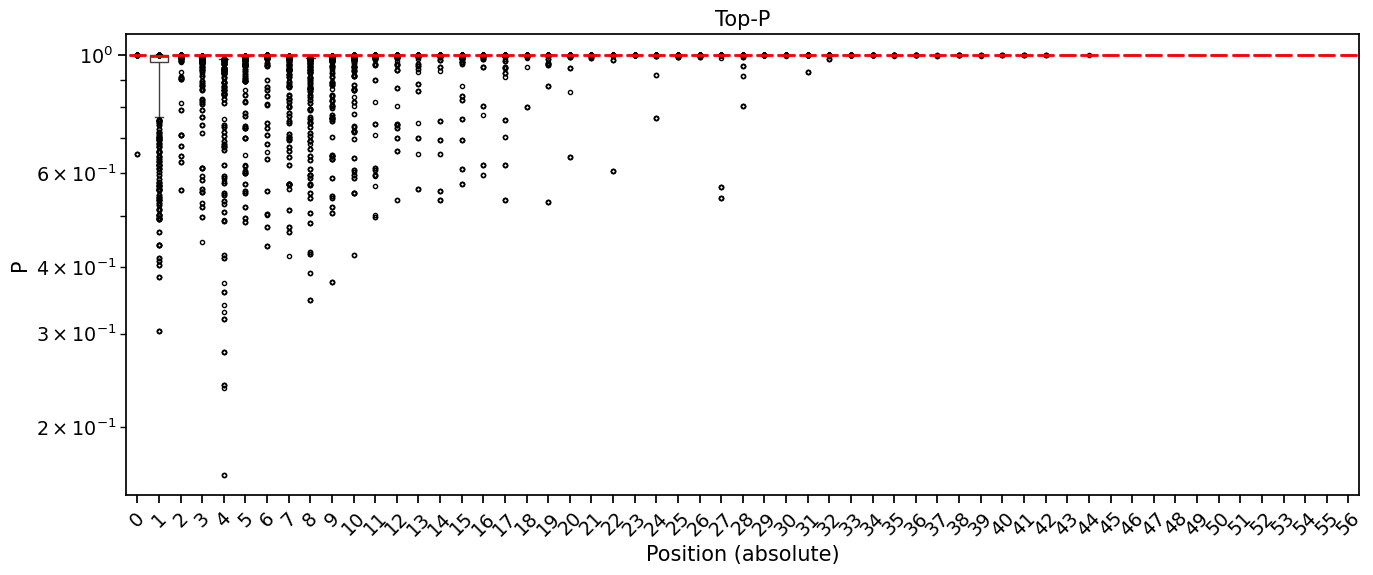

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
m_['tokzero'] = m_['tok'] - m_['start']
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="maxp", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

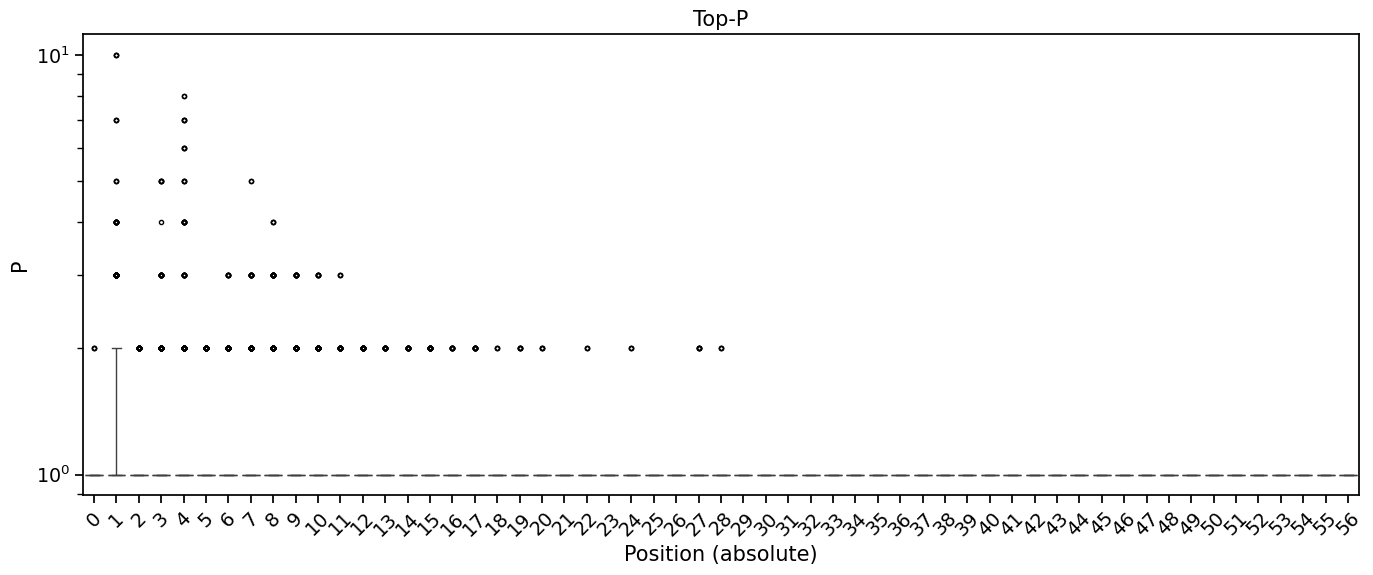

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()

m_['tokzero'] = m_['tok'] - m_['start']

sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("P")
plt.title("Top-P")


plt.tight_layout()

plt.show()

In [131]:
m_

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
38831,0,9,6471,generated,1,7.224133e-06,1.000000,6471,6486,generated,5,15,0.997687,5.000000,0,-16
38837,0,9,6472,generated,1,5.841955e-02,0.992606,6471,6486,generated,5,15,0.997842,5.066667,1,-15
38843,0,9,6473,generated,1,5.036472e-06,1.000000,6471,6486,generated,5,15,0.997996,5.133333,2,-14
38849,0,9,6474,generated,2,7.166480e-01,0.518202,6471,6486,generated,5,15,0.998150,5.200000,3,-13
38855,0,9,6475,generated,1,1.664804e-08,1.000000,6471,6486,generated,5,15,0.998304,5.266667,4,-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41258435,2,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
41258441,2,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
41258447,2,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
41258453,2,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


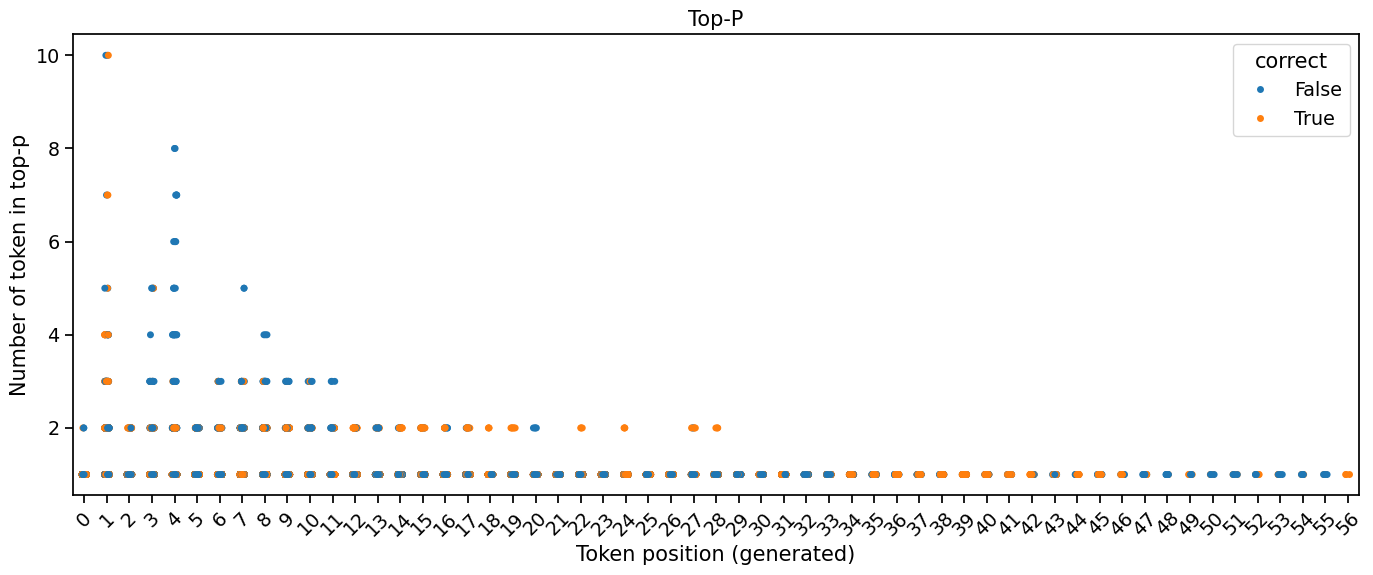

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.ylabel("Number of token in top-p")
plt.xlabel("Token position (generated)")
plt.title("Top-P")


plt.tight_layout()

plt.show()

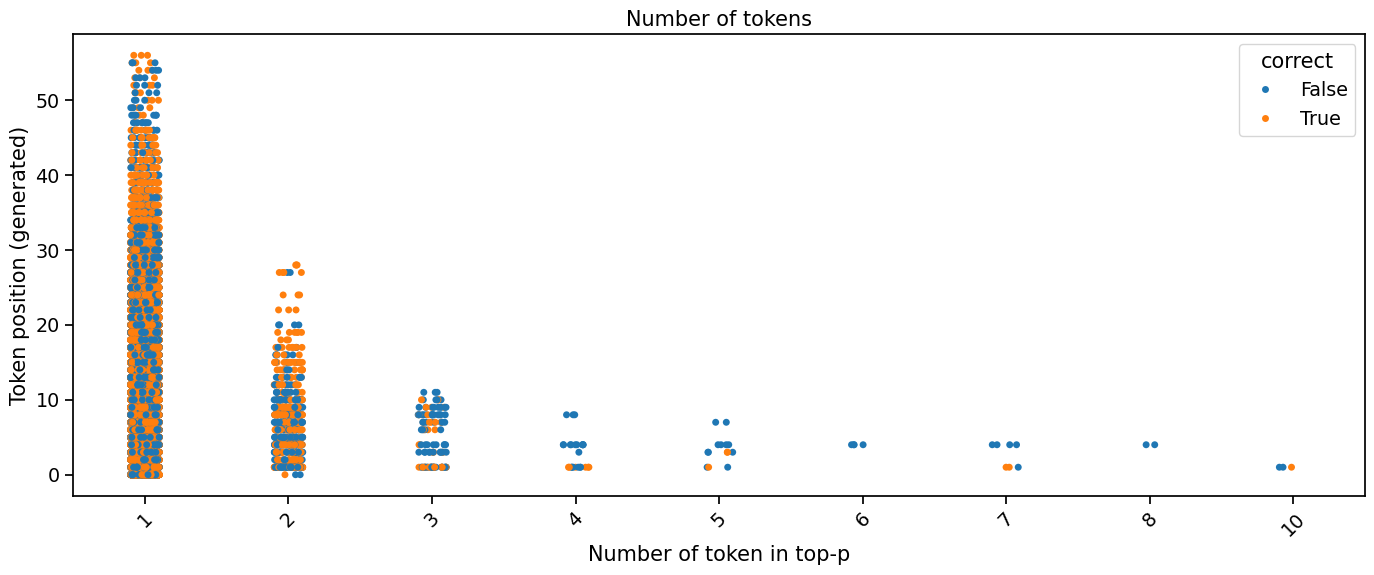

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()


m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    y="tokzero", 
    x="shape", 
    hue='correct',
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Number of token in top-p")
plt.ylabel("Token position (generated)")
plt.title("Number of tokens")


plt.tight_layout()

plt.show()

In [135]:
m_.groupby('shape').correct.agg(['count', 'mean'])

,count,mean
shape,,
1,52031,0.693452
2,982,0.509165
3,117,0.307692
4,26,0.230769
5,14,0.214286
6,4,0.000000
7,7,0.285714
8,2,0.000000
10,3,0.333333


In [136]:
# 2%
m_.groupby('shape').correct.count() / m_.groupby('shape').correct.count().sum()

shape
1     0.978284
2     0.018464
3     0.002200
4     0.000489
5     0.000263
6     0.000075
7     0.000132
8     0.000038
10    0.000056
Name: correct, dtype: float64

In [137]:
mm[mm.segment=='generated'].true_ent.describe()

count    5.318600e+04
mean     1.991356e-02
std      1.154717e-01
min      7.314307e-12
25%      4.170548e-07
50%      3.765215e-06
75%      6.900237e-05
max      2.319561e+00
Name: true_ent, dtype: float64

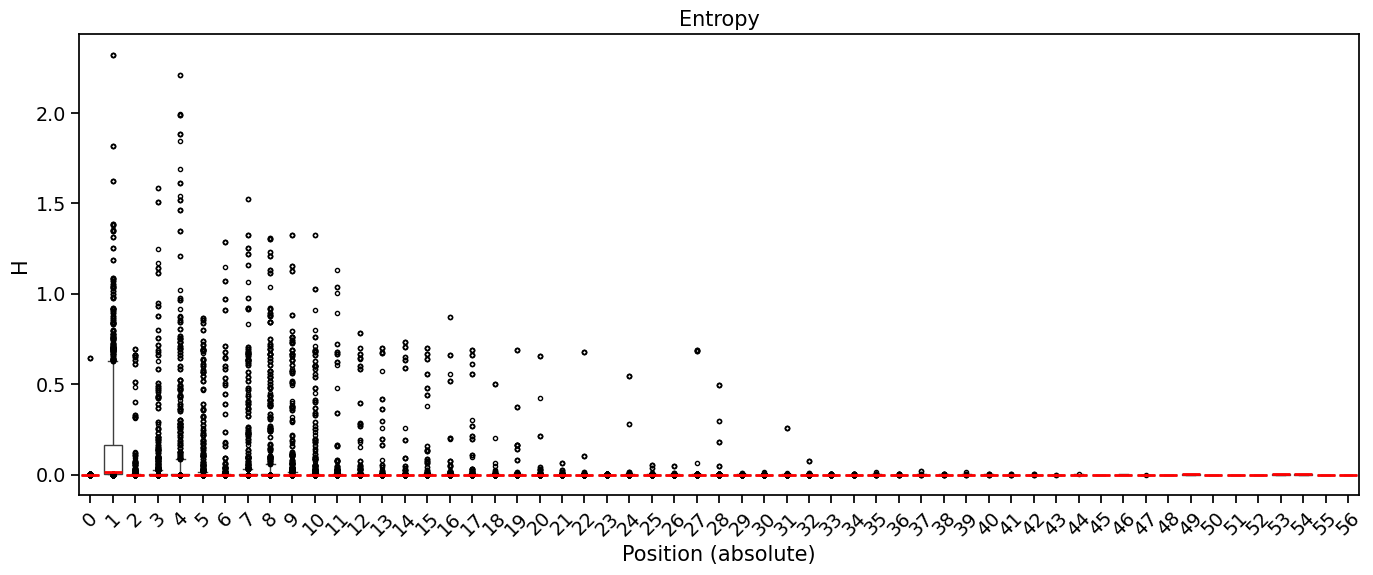

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()  # Get current axis

m_ = mm[mm.segment=='generated'].copy()
 
sns.boxplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    # hue='pid',
    showcaps=True,        
    showfliers=True,
    whis=[10, 90],
    boxprops={'facecolor': 'none'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops = dict(marker='o', markerfacecolor='None', markersize=3,  markeredgecolor='black'),
    ax = ax
)

# plt.yscale("log")

plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

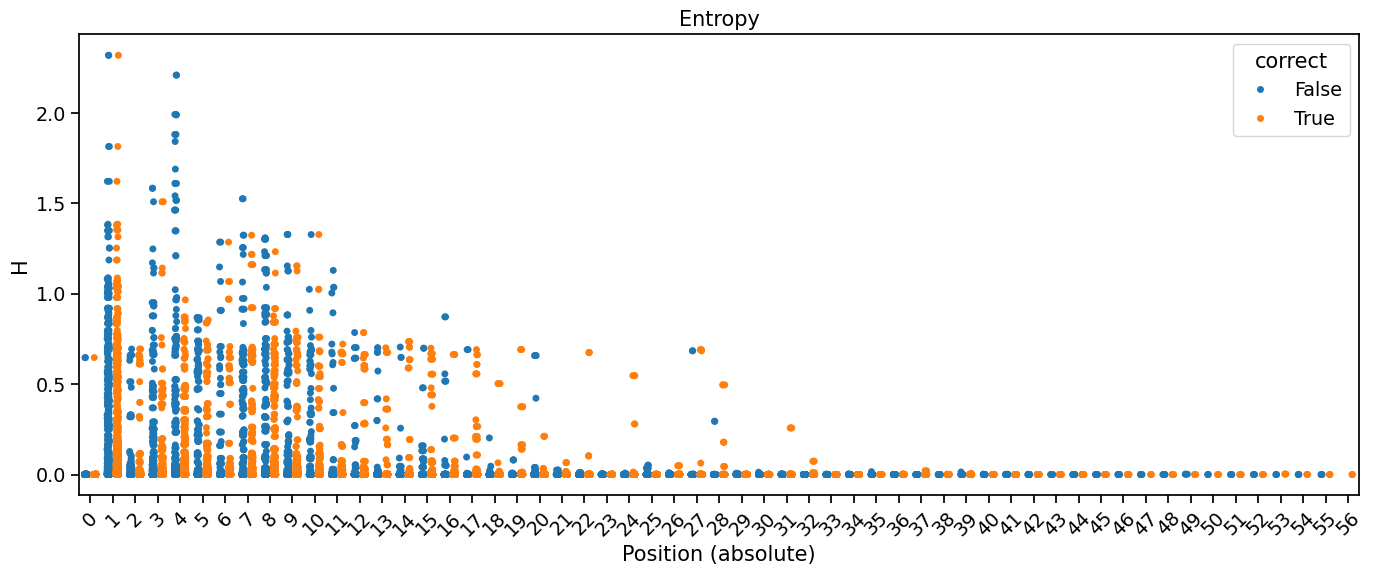

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches

plt.figure(figsize=(14, 6))
ax = plt.gca()

m_ = mm[mm.segment=='generated'].copy()

m_ = m_.merge(truth, on=['run', 'pid'])

sns.stripplot(
    data=m_, 
    x="tokzero", 
    y="true_ent", 
    hue='correct',
    dodge=True,
    size=5,
    ax = ax
)


plt.xticks(rotation=45)

plt.xlabel("Position (absolute)")
plt.ylabel("H")
plt.title("Entropy")


plt.tight_layout()

plt.show()

In [140]:
mm[(mm.segment=='generated') & (mm.pid==1)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [141]:
mm[(mm.segment=='generated') & (mm.pid==2)]

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end


In [142]:
mm.shape

(6876410, 16)

In [143]:
m.shape

(2292196, 19)

In [76]:
# TODO: compare variance in generate (same prompt / multiple prompts)

In [77]:
# TODO: compare observables grouping by truth

In [181]:
# TODO: plot truth vs aggregated uncertainty